In [1]:

import os

os.environ['JAX_PLATFORMS'] = 'cuda'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'
# os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

import astropy.coordinates as ac
import astropy.time as at
import astropy.units as au
import pylab as plt
from tomographic_kernel.frames import ENU

from dsa2000_cal.common.astropy_utils import mean_itrs
from dsa2000_common.common.quantity_utils import quantity_to_jnp
from dsa2000_fm.abc import AbstractArrayConstraint
from dsa2000_common.common.quantity_utils import quantity_to_np
from dsa2000_fm.array_layout.psf_evaluation import compute_ideal_psf_distribution, point_generator, compute_mst, \
    SampleEvaluation, evaluate_psf
from dsa2000_assets.registries import array_registry
from dsa2000_assets.content_registry import fill_registries
from dsa2000_assets.array_constraints.array_constraint_content import ArrayConstraintsV4

try:
    import tqdm
except ImportError:
    !pip install tqdm
    import tqdm
import jax
import jax.numpy as jnp
import numpy as np
import tensorflow_probability.substrates.jax as tfp

tfpd = tfp.distributions


/dsa/code/package/src/dsa2000_cal/common/mixed_precision_utils.py:10: UserWarning: JAX x64 is not enabled. Setting it now, but check for errors.
  warnings.warn("JAX x64 is not enabled. Setting it now, but check for errors.")


In [3]:




def create_lmn_total():
    lmn = []
    for inner, outer, dl, frac in [
        (0. * au.arcmin, 1. * au.arcmin, (3.3 / 7) * au.arcsec, 1.),
        (1. * au.arcmin, 0.5 * au.deg, (3.3 / 7) * au.arcsec, 0.001),
        (0.5 * au.deg, 1.5 * au.deg, (3.3 / 7) * au.arcsec, 0.0001),
    ]:
        lvec = mvec = np.arange(-outer.to('rad').value, outer.to('rad').value, dl.to('rad').value)
        L, M = np.meshgrid(lvec, mvec, indexing='ij')
        L = L.flatten()
        M = M.flatten()
        LM = L ** 2 + M ** 2
        _lmn = np.stack([L, M, 1 - np.sqrt(1 - LM)], axis=-1)
        keep = np.logical_and(np.sqrt(LM) >= inner.to('rad').value, np.sqrt(LM) < outer.to('rad').value)
        _lmn = _lmn[keep]
        print(f"Got {_lmn.shape[0]} samples")
        if frac < 1:
            select_idx = np.random.choice(_lmn.shape[0], int(frac * _lmn.shape[0]), replace=False)
            _lmn = _lmn[select_idx]
        print(f"Got {_lmn.shape[0]} samples from {inner} to {outer} with {dl} spacing")
        lmn.append(_lmn)
    lmn = jnp.concatenate(lmn, axis=0)
    print(f"Total {lmn.shape[0]} samples")
    return lmn


def create_lmn_inner():
    lmn = []
    for inner, outer, dl, frac in [
        (0. * au.arcmin, 1. * au.arcmin, (3.3 / 7) * au.arcsec, 1.)
    ]:
        lvec = mvec = np.arange(-outer.to('rad').value, outer.to('rad').value, dl.to('rad').value)
        L, M = np.meshgrid(lvec, mvec, indexing='ij')
        L = L.flatten()
        M = M.flatten()
        LM = L ** 2 + M ** 2
        _lmn = np.stack([L, M, 1 - np.sqrt(1 - LM)], axis=-1)
        keep = np.logical_and(np.sqrt(LM) >= inner.to('rad').value, np.sqrt(LM) < outer.to('rad').value)
        _lmn = _lmn[keep]
        print(f"Got {_lmn.shape[0]} samples")
        if frac < 1:
            select_idx = np.random.choice(_lmn.shape[0], int(frac * _lmn.shape[0]), replace=False)
            _lmn = _lmn[select_idx]
        print(f"Got {_lmn.shape[0]} samples from {inner} to {outer} with {dl} spacing")
        lmn.append(_lmn)
    lmn = jnp.concatenate(lmn, axis=0)
    print(f"Total {lmn.shape[0]} samples")
    return lmn


def create_target(key, lmn, freqs, decs, num_samples: int, num_antennas: int | None = None):
    fill_registries()
    array = array_registry.get_instance(array_registry.get_match('dsa2000W'))

    antennas = array.get_antennas()
    array_location = array.get_array_location()
    obstime = at.Time('2022-01-01T00:00:00', scale='utc')
    antennas_enu = antennas.get_itrs(obstime=obstime, location=array_location).transform_to(
        ENU(0, 0, 1, obstime=obstime, location=array_location)
    )
    antennas_enu_xyz = antennas_enu.cartesian.xyz.T
    latitude = array_location.geodetic.lat.rad
    antennas_enu_xyz[:, 1] /= np.cos(latitude)

    antennas_enu_xyz = jnp.asarray(antennas_enu_xyz)

    return jax.block_until_ready(
        jax.jit(
            jax.vmap(
                lambda freq, dec: compute_ideal_psf_distribution(key, lmn, freq,
                                                                 latitude, dec, antennas_enu_xyz, num_samples,
                                                                 num_antennas=num_antennas)
            )
        )(freqs, decs)
    )


evaluate_psf_jit = jax.jit(evaluate_psf)


def main(run_name: str, init_config: str | None, array_constraint: AbstractArrayConstraint,
         num_antennas: int | None = None):
    os.makedirs(run_name, exist_ok=True)
    plot_folder = os.path.join(run_name, 'plots')
    os.makedirs(plot_folder, exist_ok=True)

    key = jax.random.PRNGKey(0)
    np.random.seed(0)
    lmn_inner = create_lmn_inner()
    lmn = lmn_outer = create_lmn_total()

    freqs = [1350, 700, 2000] * au.MHz
    decs = [0, -30, 30, 60, 90] * au.deg

    freqs, decs = np.meshgrid(quantity_to_np(freqs, 'Hz'), quantity_to_np(decs, 'rad'), indexing='ij')
    freqs = jnp.asarray(freqs.flatten())
    decs = jnp.asarray(decs.flatten())

    print("Loading initial data...")
    if init_config is not None:
        coords = []
        with open(init_config, 'r') as f:
            for line in f:
                if line.startswith("#"):
                    continue
                x, y, z = line.strip().split(',')
                coords.append((float(x), float(y), float(z)))
        coords = np.asarray(coords)
        antennas0 = ac.EarthLocation.from_geocentric(
            coords[:, 0] * au.m,
            coords[:, 1] * au.m,
            coords[:, 2] * au.m
        )
        array_location = mean_itrs(antennas0.get_itrs()).earth_location
    else:
        fill_registries()
        array = array_registry.get_instance(array_registry.get_match('dsa2000_optimal_v1'))
        antennas0 = array.get_antennas()
        array_location = array.get_array_location()
    if num_antennas is not None:
        keep_idxs = np.random.choice(antennas0.shape[0], num_antennas, replace=False)
        antennas0 = antennas0[keep_idxs]
    obstime = at.Time('2021-01-01T00:00:00', format='isot', scale='utc')

    antennas = antennas0.copy()

    print("Creating target...")
    target_log_psf_mean, target_log_psf_stddev = create_target(key, lmn, freqs, decs, 1000, num_antennas=num_antennas)
    target_log_psf_mean_inner, target_log_psf_stddev_inner = create_target(key, lmn_inner,
                                                                           freqs[:1], decs[:1], 20,
                                                                           num_antennas=num_antennas)
    target_log_psf_mean_outer, target_log_psf_stddev_outer = create_target(key, lmn_outer,
                                                                           freqs[:1], decs[:1], 20,
                                                                           num_antennas=num_antennas)

    # row 1,col 1 Plot the target_log_psf_mean_inner
    # row 2,col 1 Plot the target_log_psf_stddev_inner
    # row 1,col 1 Plot the target_log_psf_mean_outer
    # row 2,col 1 Plot the target_log_psf_stddev_outer

    fig, axs = plt.subplots(2, 2, figsize=(16, 16))
    sc = axs[0, 0].scatter(lmn_inner[..., 0].flatten(), lmn_inner[..., 1].flatten(),
                           c=target_log_psf_mean_inner.flatten(), s=1, cmap='jet', marker='.',
                           vmin=-60, vmax=10 * np.log10(0.5))
    plt.colorbar(sc, ax=axs[0, 0], label='Power (dB)')
    axs[0, 0].set_xlabel('l (proj.rad)')
    axs[0, 0].set_ylabel('m (proj.rad)')
    axs[0, 0].set_title('Target mean inner PSF')
    sc = axs[1, 0].scatter(lmn_inner[..., 0].flatten(), lmn_inner[..., 1].flatten(),
                           c=target_log_psf_stddev_inner.flatten(), s=1,
                           cmap='jet', marker='.')
    plt.colorbar(sc, ax=axs[1, 0], label='Power (dB)')
    axs[1, 0].set_xlabel('l (proj.rad)')
    axs[1, 0].set_ylabel('m (proj.rad)')
    axs[1, 0].set_title('Target stddev inner PSF')
    sc = axs[0, 1].scatter(lmn_outer[..., 0].flatten(), lmn_outer[..., 1].flatten(),
                           c=target_log_psf_mean_outer.flatten(), s=1, cmap='jet', marker='.',
                           vmin=-60, vmax=10 * np.log10(0.5))
    plt.colorbar(sc, ax=axs[0, 1], label='Power (dB)')
    axs[0, 1].set_xlabel('l (proj.rad)')
    axs[0, 1].set_ylabel('m (proj.rad)')
    axs[0, 1].set_title('Target mean outer PSF')
    sc = axs[1, 1].scatter(lmn_outer[..., 0].flatten(), lmn_outer[..., 1].flatten(),
                           c=target_log_psf_stddev_outer.flatten(), s=1,
                           cmap='jet', marker='.')
    plt.colorbar(sc, ax=axs[1, 1], label='Power (dB)')
    axs[1, 1].set_xlabel('l (proj.rad)')
    axs[1, 1].set_ylabel('m (proj.rad)')
    axs[1, 1].set_title('Target stddev outer PSF')
    fig.savefig(os.path.join(plot_folder, f'target_psf.png'))
    plt.close(fig)

    # Performing the optimization

    gen = point_generator(
        results_file=os.path.join(run_name, 'results.json'),
        plot_dir=plot_folder,
        array_constraint=array_constraint,
        antennas=antennas,
        array_location=array_location,
        obstime=obstime,
        additional_buffer=0 * au.m,
        minimal_antenna_sep=8 * au.m
    )

    gen_response = None
    while True:
        try:
            sample_point = gen.send(gen_response)
        except StopIteration:
            break
        quality = evaluate_psf_jit(
            antennas_enu=quantity_to_jnp(
                sample_point.antennas.get_itrs(obstime=obstime, location=array_location).transform_to(
                    ENU(obstime=obstime, location=array_location)
                ).cartesian.xyz.T, 'm'
            ),
            lmn=lmn,
            latitude=quantity_to_jnp(sample_point.latitude, 'rad'),
            freqs=freqs,
            decs=decs,
            target_log_psf_mean=target_log_psf_mean,
            target_log_psf_stddev=target_log_psf_stddev
        )
        cost, _, _ = compute_mst(
            k=6,
            antennas=sample_point.antennas,
            obstime=obstime,
            array_location=array_location,
            plot=False,
            save_file='mst'
        )
        gen_response = SampleEvaluation(
            quality=quality,
            cost=cost,
            antennas=sample_point.antennas
        )


if __name__ == '__main__':
    import warnings

    # Suppress specific UserWarnings
    # warnings.filterwarnings(
    #     "ignore",
    #     category=UserWarning,
    #     module="pyogrio"
    # )
    warnings.filterwarnings(
        "ignore",
        category=UserWarning
    )

    # main(init_config='/dsa/code/package/scripts/optimise_array_layout/init_config.txt')
    # main(init_config='solution_dec_with_expansion_long.txt')
    main(init_config=None, run_name='pareto_opt', num_antennas=None, array_constraint=ArrayConstraintsV4())




Got 50880 samples
Got 50880 samples from 0.0 arcmin to 1.0 arcmin with 0.4714285714285714 arcsec spacing
Total 50880 samples
Got 50880 samples
Got 50880 samples from 0.0 arcmin to 1.0 arcmin with 0.4714285714285714 arcsec spacing
Got 45748834 samples
Got 45748 samples from 1.0 arcmin to 0.5 deg with 0.4714285714285714 arcsec spacing
Got 366397932 samples
Got 36639 samples from 0.5 deg to 1.5 deg with 0.4714285714285714 arcsec spacing
Total 133267 samples
Loading initial data...
Violation at antenna0 2030. Replacing...
Creating target...


Best Chi2: 4.55, optimizing antenna 1711, 255 successes, efficiency 0.01589082071415218...: : 16048it [6:40:23,  1.48s/it] 

KeyboardInterrupt: 

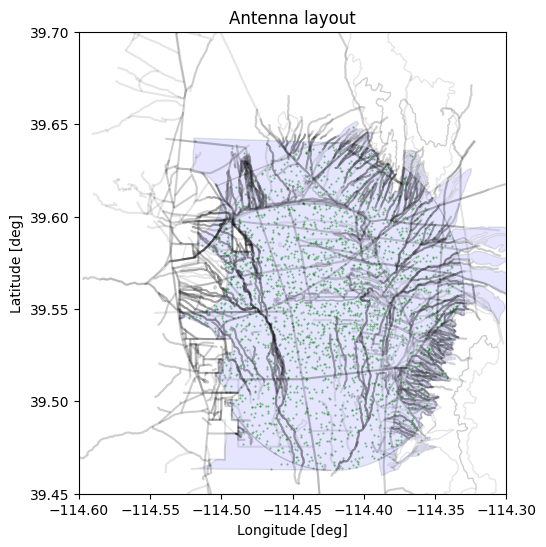